## Importing Libraries

In [1]:
import hdf5storage
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import TimeSeriesSplit
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.metrics import confusion_matrix
import keras
from keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D
from keras.models import Model
from keras.preprocessing.sequence import TimeseriesGenerator

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

## Getting the data

In [2]:
LOB = hdf5storage.loadmat('S092215-v50-AMZN_OCT2_states.mat')
Amazon_data = pd.DataFrame.from_dict(LOB['LOB'])

In [3]:
Amazon_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42
0,1442894410000,0,0,0,0,5427400,100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1442894410000,5452100,49400,5476800,100,5427400,100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1442894410073,5451900,49000,5476400,100,5427400,100,5476800,100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1442894410073,5452000,48800,5476400,100,5427600,100,5476800,100,5427400,100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1442894410073,5452000,48800,5476400,100,5427600,100,5476800,100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [4]:
Amazon_data.shape

(562650, 43)

## Organising a few things

### Changing column names accroding to time, mid_price, spread and, ask and bid price levels

In [5]:
Amazon_data.columns = [
                      "Time", "Mid_Price", "Spread", 
                      "AskPrice1", "AskVolume1","BidPrice1", "BidVolume1", # Level 1
                      "AskPrice2", "AskVolume2","BidPrice2", "BidVolume2", # Level 2
                      "AskPrice3", "AskVolume3","BidPrice3", "BidVolume3", # Level 3
                      "AskPrice4", "AskVolume4","BidPrice4", "BidVolume4", # Level 4
                      "AskPrice5", "AskVolume5","BidPrice5", "BidVolume5", # Level 5
                      "AskPrice6", "AskVolume6","BidPrice6", "BidVolume6", # Level 6
                      "AskPrice7", "AskVolume7","BidPrice7", "BidVolume7", # Level 7
                      "AskPrice8", "AskVolume8","BidPrice8", "BidVolume8", # Level 8
                      "AskPrice9", "AskVolume9","BidPrice9", "BidVolume9", # Level 9
                      "AskPrice10", "AskVolume10","BidPrice10", "BidVolume10", # Level 10
                     ]
Amazon_data.head()


,Time,Mid_Price,Spread,AskPrice1,AskVolume1,BidPrice1,BidVolume1,AskPrice2,AskVolume2,BidPrice2,BidVolume2,AskPrice3,AskVolume3,BidPrice3,BidVolume3,AskPrice4,AskVolume4,BidPrice4,BidVolume4,AskPrice5,AskVolume5,BidPrice5,BidVolume5,AskPrice6,AskVolume6,BidPrice6,BidVolume6,AskPrice7,AskVolume7,BidPrice7,BidVolume7,AskPrice8,AskVolume8,BidPrice8,BidVolume8,AskPrice9,AskVolume9,BidPrice9,BidVolume9,AskPrice10,AskVolume10,BidPrice10,BidVolume10
0,1442894410000,0,0,0,0,5427400,100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1442894410000,5452100,49400,5476800,100,5427400,100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1442894410073,5451900,49000,5476400,100,5427400,100,5476800,100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1442894410073,5452000,48800,5476400,100,5427600,100,5476800,100,5427400,100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1442894410073,5452000,48800,5476400,100,5427600,100,5476800,100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Converting time to readable format

In [6]:
new_time = []
for item in Amazon_data["Time"]:
    current = datetime.datetime.fromtimestamp(item/1000.0)
    new_time.append(current)

readable_time = []
for i in range(0,len(new_time)):
    current_time = new_time[i].strftime("%H:%M:%f")
    readable_time.append(current_time) 

Amazon_data['Time'] = readable_time 
Amazon_data['Time'] = pd.to_datetime(Amazon_data['Time'], format="%H:%M:%f")
Amazon_data['Time'] = Amazon_data['Time'].dt.time
Amazon_data.head()

,Time,Mid_Price,Spread,AskPrice1,AskVolume1,BidPrice1,BidVolume1,AskPrice2,AskVolume2,BidPrice2,BidVolume2,AskPrice3,AskVolume3,BidPrice3,BidVolume3,AskPrice4,AskVolume4,BidPrice4,BidVolume4,AskPrice5,AskVolume5,BidPrice5,BidVolume5,AskPrice6,AskVolume6,BidPrice6,BidVolume6,AskPrice7,AskVolume7,BidPrice7,BidVolume7,AskPrice8,AskVolume8,BidPrice8,BidVolume8,AskPrice9,AskVolume9,BidPrice9,BidVolume9,AskPrice10,AskVolume10,BidPrice10,BidVolume10
0,05:00:00,0,0,0,0,5427400,100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,05:00:00,5452100,49400,5476800,100,5427400,100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,05:00:00.073000,5451900,49000,5476400,100,5427400,100,5476800,100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,05:00:00.073000,5452000,48800,5476400,100,5427600,100,5476800,100,5427400,100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,05:00:00.073000,5452000,48800,5476400,100,5427600,100,5476800,100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Plotting a small sample of data to see how our data looks like

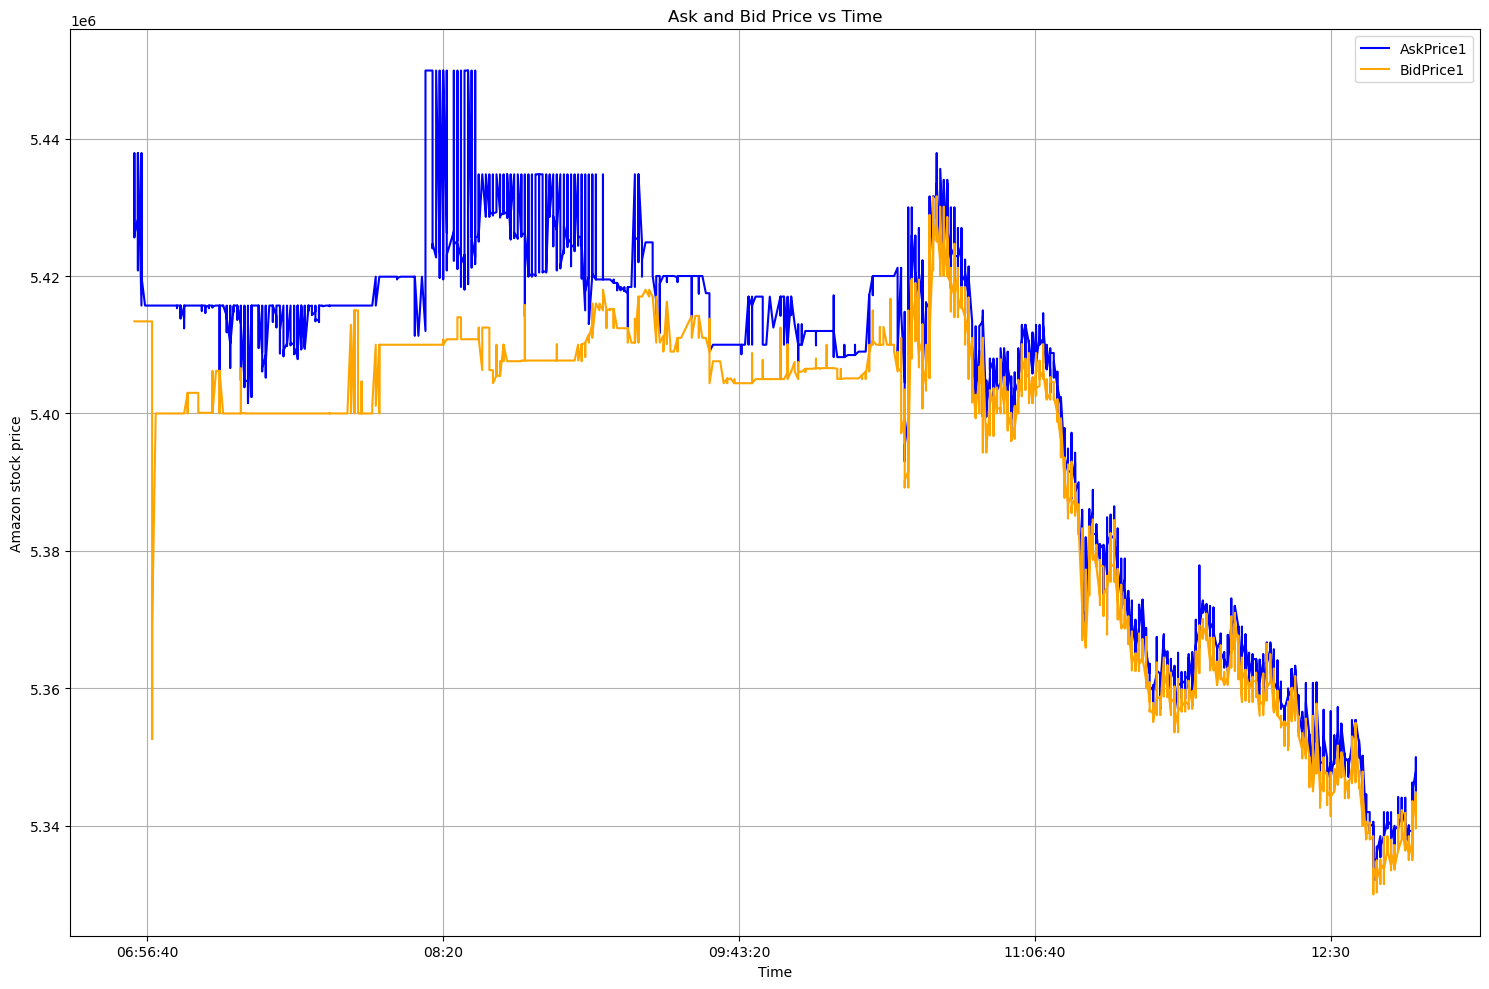

In [7]:
sample_data = Amazon_data.iloc[56000:255700,]

sample_data.plot(x='Time', y=['AskPrice1', 'BidPrice1'], 
                 figsize=(15,10), color=['blue', 'orange'])
plt.title('Ask and Bid Price vs Time')
plt.xlabel('Time')
plt.ylabel('Amazon stock price')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show();

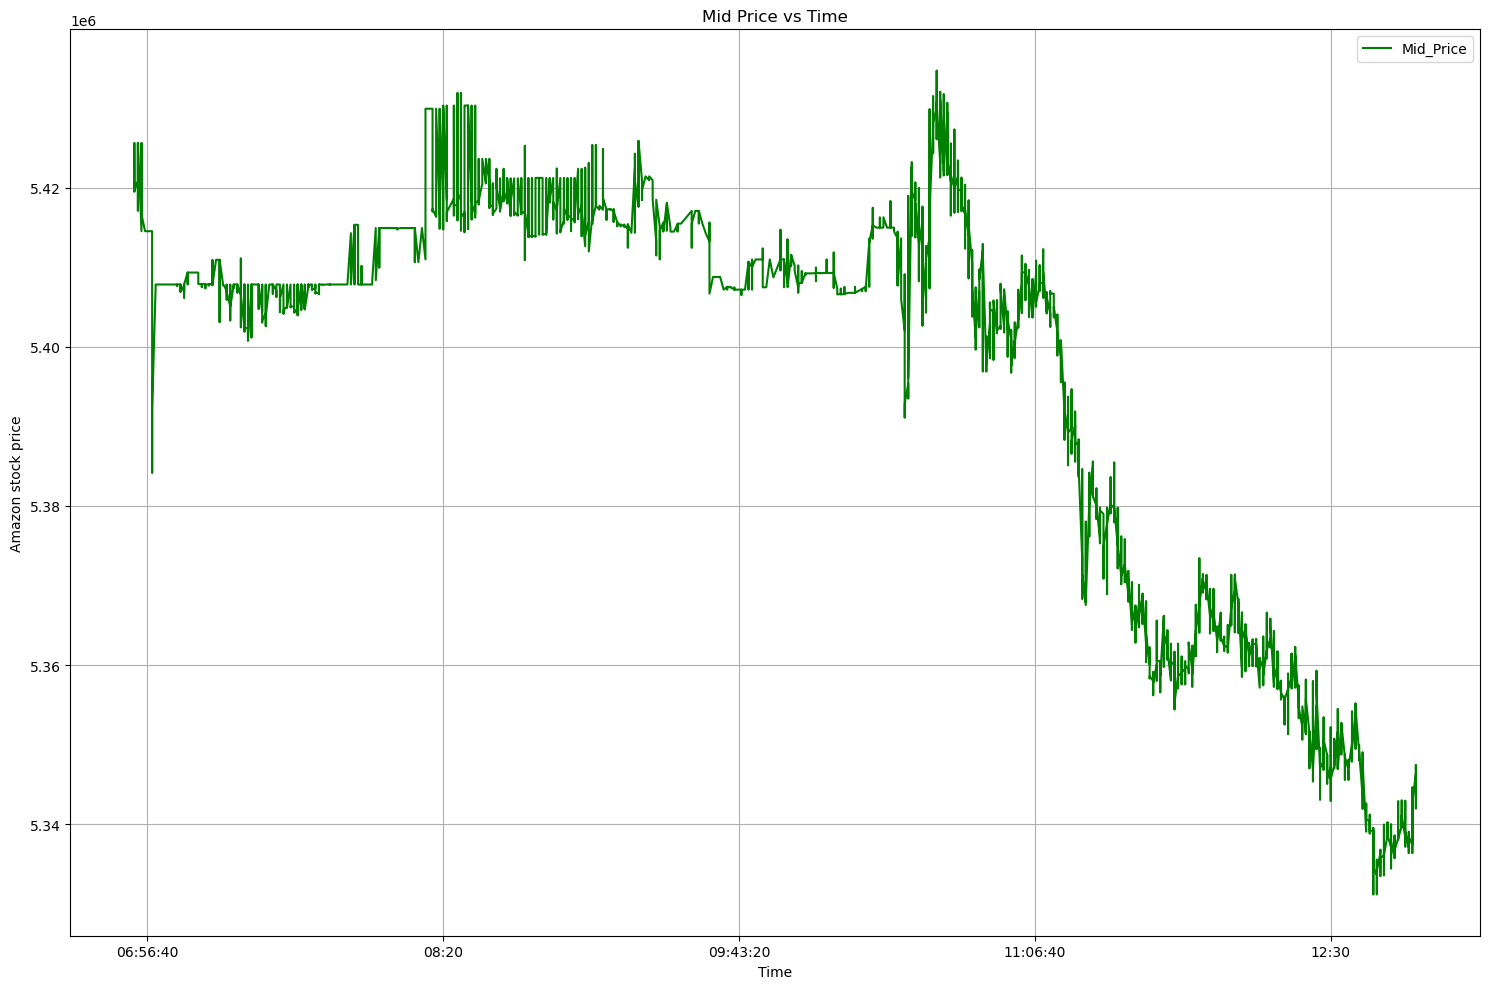

In [8]:
sample_data.plot(x='Time', y='Mid_Price', 
                 figsize=(15,10), color='green')
plt.title('Mid Price vs Time')
plt.xlabel('Time')
plt.ylabel('Amazon stock price')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show();

## Feature Engineering

In [9]:
# Feature 1: Price difference between current and previous time step
Amazon_data['PriceDifference'] = Amazon_data['Mid_Price'].diff()

#Feature 2: Price volatility (rolling standard deviation of PriceDifference)
Amazon_data['Volatility'] = Amazon_data['PriceDifference'].rolling(window=10).std()

#Feature 3: Total ask and bid volumes
Amazon_data['TotalAskVolume'] = Amazon_data['AskVolume1'] + Amazon_data['AskVolume2'] + Amazon_data['AskVolume3'] + Amazon_data['AskVolume4'] + Amazon_data['AskVolume5'] + Amazon_data['AskVolume6'] + Amazon_data['AskVolume7'] + Amazon_data['AskVolume8'] + Amazon_data['AskVolume9'] + Amazon_data['AskVolume10']
Amazon_data['TotalBidVolume'] = Amazon_data['BidVolume1'] + Amazon_data['BidVolume2'] + Amazon_data['BidVolume3'] + Amazon_data['BidVolume4'] + Amazon_data['BidVolume5'] + Amazon_data['BidVolume6'] + Amazon_data['BidVolume7'] + Amazon_data['BidVolume8'] + Amazon_data['BidVolume9'] + Amazon_data['BidVolume10'] 

#Feature 6: Moving average mid-price
Amazon_data['MovingAverage10'] = Amazon_data['Mid_Price'].rolling(window=10).mean()

#Feature 7: Momentum (difference by current price and moving average)
Amazon_data['Momentum'] = Amazon_data['Mid_Price'] - Amazon_data['MovingAverage10']

#Feature 8: Price ratio between price at the current and previous time stamp
Amazon_data['PriceRatio'] = Amazon_data['Mid_Price']/Amazon_data['Mid_Price'].shift(1)

#Feature 9: Order Imbalance i.e. the ratio of the difference and the sum between the best ask and bid volumes
Amazon_data['OrderImbalance'] = (Amazon_data['BidVolume1'] - Amazon_data['AskVolume1'])/(Amazon_data['BidVolume1'] + Amazon_data['AskVolume1'])

In [10]:
Amazon_data.dropna(inplace=True)
Amazon_data.index = np.arange(0, len(Amazon_data))
Amazon_data

,Time,Mid_Price,Spread,AskPrice1,AskVolume1,BidPrice1,BidVolume1,AskPrice2,AskVolume2,BidPrice2,BidVolume2,AskPrice3,AskVolume3,BidPrice3,BidVolume3,AskPrice4,AskVolume4,BidPrice4,BidVolume4,AskPrice5,AskVolume5,BidPrice5,BidVolume5,AskPrice6,AskVolume6,BidPrice6,BidVolume6,AskPrice7,AskVolume7,BidPrice7,BidVolume7,AskPrice8,AskVolume8,BidPrice8,BidVolume8,AskPrice9,AskVolume9,BidPrice9,BidVolume9,AskPrice10,AskVolume10,BidPrice10,BidVolume10,PriceDifference,Volatility,TotalAskVolume,TotalBidVolume,MovingAverage10,Momentum,PriceRatio,OrderImbalance
0,05:00:00.395000,5455800,56400,5484000,100,5427600,100,5484200,100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,1.723976e+06,200,100,5452740.0,3060.0,1.000000,0.000000
1,05:00:00.395000,5452000,48800,5476400,100,5427600,100,5484000,100,0,0,5484200,100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-3800.0,1.816865e+03,300,100,5452730.0,-730.0,0.999303,0.000000
2,05:00:00.395000,5452000,48800,5476400,100,5427600,100,5484200,100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,1.815642e+03,200,100,5452740.0,-740.0,1.000000,0.000000
3,05:00:00.467000,5452050,48700,5476400,100,5427700,100,5484200,100,5427600,100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,50.0,1.815435e+03,200,200,5452745.0,-695.0,1.000009,0.000000
4,05:00:00.467000,5452000,48600,5476300,100,5427700,100,5476400,100,5427600,100,5484200,100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-50.0,1.815520e+03,300,200,5452745.0,-745.0,0.999991,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561558,21:00:00.092000,5345000,90000,5390000,100,5300000,10,0,0,5190000,50,0,0,4900000,10,0,0,4200000,20,0,0,3777700,30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,8.078505e+03,100,120,5356390.0,-11390.0,1.000000,-0.818182
561559,21:00:00.092000,5345000,90000,5390000,100,5300000,10,0,0,5190000,50,0,0,4200000,20,0,0,3777700,30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,8.078505e+03,100,110,5353355.0,-8355.0,1.000000,-0.818182
561560,21:00:00.092000,5345000,90000,5390000,100,5300000,10,0,0,5190000,50,0,0,4200000,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,8.123972e+03,100,80,5350470.0,-5470.0,1.000000,-0.818182
561561,21:00:00.093000,5290000,200000,5390000,100,5190000,50,0,0,4200000,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-55000.0,1.825480e+04,100,70,5342085.0,-52085.0,0.989710,-0.333333


In [11]:
Amazon_data.shape

(561563, 51)

## Feature Selection

In [12]:
Feature_Matrix = Amazon_data.drop(["Time","Mid_Price",
                                    "AskPrice3", "AskVolume3", "BidPrice3", "BidVolume3", # Level 3
                                    "AskPrice4", "AskVolume4","BidPrice4", "BidVolume4", # Level 4
                                    "AskPrice5", "AskVolume5","BidPrice5", "BidVolume5", # Level 5
                                    "AskPrice6", "AskVolume6","BidPrice6", "BidVolume6", # Level 6
                                    "AskPrice7", "AskVolume7","BidPrice7", "BidVolume7", # Level 7
                                    "AskPrice8", "AskVolume8","BidPrice8", "BidVolume8", # Level 8
                                    "AskPrice9", "AskVolume9","BidPrice9", "BidVolume9", # Level 9
                                    "AskPrice10", "AskVolume10","BidPrice10", "BidVolume10"], 
                                  axis=1, inplace=False)
Feature_Matrix

,Spread,AskPrice1,AskVolume1,BidPrice1,BidVolume1,AskPrice2,AskVolume2,BidPrice2,BidVolume2,PriceDifference,Volatility,TotalAskVolume,TotalBidVolume,MovingAverage10,Momentum,PriceRatio,OrderImbalance
0,56400,5484000,100,5427600,100,5484200,100,0,0,0.0,1.723976e+06,200,100,5452740.0,3060.0,1.000000,0.000000
1,48800,5476400,100,5427600,100,5484000,100,0,0,-3800.0,1.816865e+03,300,100,5452730.0,-730.0,0.999303,0.000000
2,48800,5476400,100,5427600,100,5484200,100,0,0,0.0,1.815642e+03,200,100,5452740.0,-740.0,1.000000,0.000000
3,48700,5476400,100,5427700,100,5484200,100,5427600,100,50.0,1.815435e+03,200,200,5452745.0,-695.0,1.000009,0.000000
4,48600,5476300,100,5427700,100,5476400,100,5427600,100,-50.0,1.815520e+03,300,200,5452745.0,-745.0,0.999991,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561558,90000,5390000,100,5300000,10,0,0,5190000,50,0.0,8.078505e+03,100,120,5356390.0,-11390.0,1.000000,-0.818182
561559,90000,5390000,100,5300000,10,0,0,5190000,50,0.0,8.078505e+03,100,110,5353355.0,-8355.0,1.000000,-0.818182
561560,90000,5390000,100,5300000,10,0,0,5190000,50,0.0,8.123972e+03,100,80,5350470.0,-5470.0,1.000000,-0.818182
561561,200000,5390000,100,5190000,50,0,0,4200000,20,-55000.0,1.825480e+04,100,70,5342085.0,-52085.0,0.989710,-0.333333


In [13]:
Feature_Matrix_range_corrected = np.nan_to_num(Feature_Matrix, nan=0.0, posinf=1e15, neginf=-1e15)

In [14]:

thresholder = VarianceThreshold(threshold = 0.95)
thresholder.fit(Feature_Matrix_range_corrected)
Features_High_Variance = thresholder.fit_transform(Feature_Matrix_range_corrected)
Features_High_Variance = pd.DataFrame(Features_High_Variance)
Features_High_Variance.columns = ["Spread", 
                      "AskPrice1", "AskVolume1","BidPrice1", "BidVolume1", # Level 1
                      "AskPrice2", "AskVolume2","BidPrice2", "BidVolume2", # Level 2
                      "PriceDifference", "Volatility", "TotalAskVolume", "TotalBidVolume",	
                      "MovingAverage10", "Momentum", "PriceRatio"                 
]
Features_High_Variance

,Spread,AskPrice1,AskVolume1,BidPrice1,BidVolume1,AskPrice2,AskVolume2,BidPrice2,BidVolume2,PriceDifference,Volatility,TotalAskVolume,TotalBidVolume,MovingAverage10,Momentum,PriceRatio
0,56400.0,5484000.0,100.0,5427600.0,100.0,5484200.0,100.0,0.0,0.0,0.0,1.723976e+06,200.0,100.0,5452740.0,3060.0,1.000000
1,48800.0,5476400.0,100.0,5427600.0,100.0,5484000.0,100.0,0.0,0.0,-3800.0,1.816865e+03,300.0,100.0,5452730.0,-730.0,0.999303
2,48800.0,5476400.0,100.0,5427600.0,100.0,5484200.0,100.0,0.0,0.0,0.0,1.815642e+03,200.0,100.0,5452740.0,-740.0,1.000000
3,48700.0,5476400.0,100.0,5427700.0,100.0,5484200.0,100.0,5427600.0,100.0,50.0,1.815435e+03,200.0,200.0,5452745.0,-695.0,1.000009
4,48600.0,5476300.0,100.0,5427700.0,100.0,5476400.0,100.0,5427600.0,100.0,-50.0,1.815520e+03,300.0,200.0,5452745.0,-745.0,0.999991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561558,90000.0,5390000.0,100.0,5300000.0,10.0,0.0,0.0,5190000.0,50.0,0.0,8.078505e+03,100.0,120.0,5356390.0,-11390.0,1.000000
561559,90000.0,5390000.0,100.0,5300000.0,10.0,0.0,0.0,5190000.0,50.0,0.0,8.078505e+03,100.0,110.0,5353355.0,-8355.0,1.000000
561560,90000.0,5390000.0,100.0,5300000.0,10.0,0.0,0.0,5190000.0,50.0,0.0,8.123972e+03,100.0,80.0,5350470.0,-5470.0,1.000000
561561,200000.0,5390000.0,100.0,5190000.0,50.0,0.0,0.0,4200000.0,20.0,-55000.0,1.825480e+04,100.0,70.0,5342085.0,-52085.0,0.989710


## Defining the dependent and the independent variables

In [15]:
returns = Amazon_data['Mid_Price']/Amazon_data['Mid_Price'].shift(1)- 1
positive = returns[returns >= 0].index
negative = returns[returns < 0].index
returns.loc[positive] = 1
returns.loc[negative] = 0
returns.dropna(inplace=True)
Amazon_data['returns'] = returns

#Independent variable
X = Features_High_Variance

#Dependent variable
mid_price = Amazon_data['Mid_Price'].values

print('Dependent variables: {}'.format(X.shape))
print('Forcasting variable=> Categorical: {} | Continuous: {}'.format(returns.shape, mid_price.shape))

Dependent variables: (561563, 16)
Forcasting variable=> Categorical: (561562,) | Continuous: (561563,)


In [16]:
tscv = TimeSeriesSplit()
for i,(train_index, test_index) in enumerate(tscv.split(X)):
    print('FOLD: {}\n'.format(i+1))
    print('Training set: {}|{}\n'.format(train_index, len(train_index)))
    print('Testing set: {}|{}'.format(test_index, len(test_index)))
    print('#'*80)
    print()

FOLD: 1

Training set: [    0     1     2 ... 93595 93596 93597]

Testing set: [ 93598  93599  93600 ... 187188 187189 187190]
################################################################################

FOLD: 2

Training set: [     0      1      2 ... 187188 187189 187190]

Testing set: [187191 187192 187193 ... 280781 280782 280783]
################################################################################

FOLD: 3

Training set: [     0      1      2 ... 280781 280782 280783]

Testing set: [280784 280785 280786 ... 374374 374375 374376]
################################################################################

FOLD: 4

Training set: [     0      1      2 ... 374374 374375 374376]

Testing set: [374377 374378 374379 ... 467967 467968 467969]
################################################################################

FOLD: 5

Training set: [     0      1      2 ... 467967 467968 467969]

Testing set: [467970 467971 467972 ... 561560 561561 561562]
#############

## Classifying mid-price

In [17]:
classifiers = {
    'Bernoulli Naive Bayes': BernoulliNB(),
    'Gaussian Naive Bayes': GaussianNB()    
    }

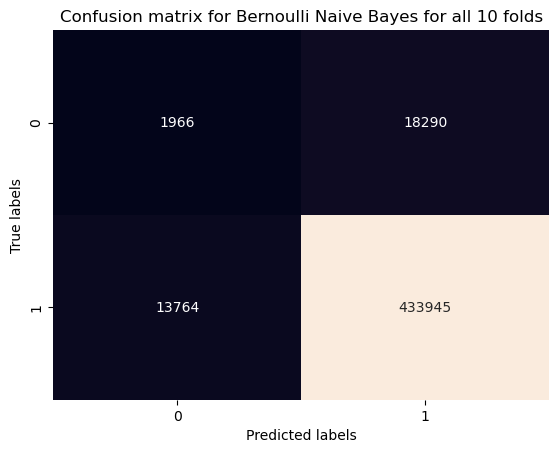

Evaluation metrics for model: Bernoulli Naive Bayes
Accuracy = 0.9315034244013976
Specificity = 0.09705766192733017
Precison = 0.95955642530985
Recall = 0.9692568163695615
################################################################################


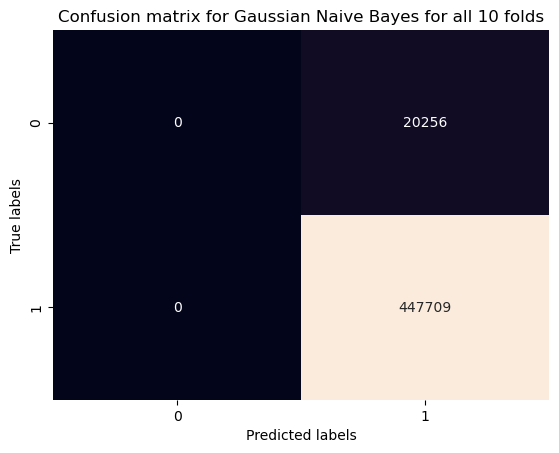

Evaluation metrics for model: Gaussian Naive Bayes
Accuracy = 0.9567147115703097
Specificity = 0.0
Precison = 0.9567147115703097
Recall = 1.0
################################################################################


In [18]:
for name, model in classifiers.items():
    CMs = []
    final_CMs = []
    for i, (train_index, test_index) in enumerate(tscv.split(X[1:])):

        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train, y_test = returns.iloc[train_index], returns.iloc[test_index]

        model.fit(X_train, y_train)
        returns_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, returns_pred) 
        CMs.append(cm)

    final_CMs.append(np.sum(CMs, axis=0))
    sns.heatmap([i for i in final_CMs[0]], cbar=False, annot=True, fmt='g')
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.title("Confusion matrix for {} for all 5 folds".format(name))
    plt.show()

    for cm in final_CMs:
        TN = cm[0][0]
        FN = cm[1][0]
        TP = cm[1][1]
        FP = cm[0][1]
        
        # Specificity or true negative rate
        Specificity = TN/(TN+FP) 
        # Precision or positive predictive value
        Precison = TP/(TP+FP)
        #Recall
        Recall = TP/(TP+FN)
        # Overall accuracy
        Accuracy = (TP+TN)/(TP+FP+FN+TN)

        print('Evaluation metrics for model: {}'.format(name))
        print('Accuracy = {}'.format(Accuracy))
        print('Specificity = {}'.format(Specificity))
        print('Precison = {}'.format(Precison))
        print('Recall = {}'.format(Recall))
        print('#'*80)

## Forecasting mid-price

In [36]:
for i, (train_index, test_index) in enumerate(tscv.split(X)):
    print("Fold: {}\n".format(i+1))
    print("TRAIN:", len(train_index), "TEST:", len(test_index))
    
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = mid_price[train_index], mid_price[test_index]

    X_train_to_Numpy = pd.DataFrame(X_train).to_numpy()
    y_train_to_Numpy = pd.DataFrame(y_train).to_numpy()

    look_back = 10
    x_train_append_matrix = []
    y_train_append_matrix = []

    for j in range(len(X_train)-look_back):         
        X_current_train = X_train_to_Numpy[j:j+look_back, :]
        y_current_train = y_train_to_Numpy[j+look_back]
        x_train_append_matrix.append(X_current_train)
        y_train_append_matrix.append(y_current_train)

    X_train_numpy = np.array(x_train_append_matrix)
    Y_train_numpy = np.array(y_train_append_matrix)

    input_shape = (look_back, X_train_numpy.shape[2])

    inputs = Input(shape=input_shape)
    x = Conv1D(32, 16, activation='linear', padding='same')(inputs)
    x = MaxPooling1D(2, padding='same')(x)
    x = Conv1D(16, 16, activation='linear', padding='same')(x)
    encoded = MaxPooling1D(2, padding='same')(x)

    x = Conv1D(16, 16, activation='linear', padding='same')(encoded)
    x = UpSampling1D(2)(x)
    x = Conv1D(32, 16, activation='linear', padding='same')(x)
    x = UpSampling1D(2)(x)
    decoded = Conv1D(1, 16, activation='linear', padding='same')(x)

    model = keras.Model(inputs, decoded)
    model.compile(optimizer='adam', loss='mse', metrics=['mse'])
    h = model.fit(X_train_numpy, Y_train_numpy, epochs=5, batch_size=32)
    result = pd.DataFrame(h.history)
    encoder = Model(inputs, encoded)
    encoded_data = encoder.predict(X_train_numpy)
    print('#'*80)

Fold: 1

TRAIN: 93598 TEST: 93593
Epoch 1/5
2925/2925 [==============================] - 13s 4ms/step - loss: nan - mse: nan
Epoch 2/5
2925/2925 [==============================] - 13s 4ms/step - loss: nan - mse: nan
Epoch 3/5
2925/2925 [==============================] - 13s 4ms/step - loss: nan - mse: nan
Epoch 4/5
2925/2925 [==============================] - 13s 4ms/step - loss: nan - mse: nan
Epoch 5/5
2925/2925 [==============================] - 5s 2ms/step
################################################################################
Fold: 2

TRAIN: 187191 TEST: 93593
Epoch 1/5
5850/5850 [==============================] - 30s 5ms/step - loss: nan - mse: nan
Epoch 2/5
5850/5850 [==============================] - 29s 5ms/step - loss: nan - mse: nan
Epoch 3/5
5850/5850 [==============================] - 25s 4ms/step - loss: nan - mse: nan
Epoch 4/5
5850/5850 [==============================] - 25s 4ms/step - loss: nan - mse: nan
Epoch 5/5
5850/5850 [==============================] - 

In [37]:
print(result)

   loss  mse
0   NaN  NaN
1   NaN  NaN
2   NaN  NaN
3   NaN  NaN
4   NaN  NaN
